<a href="https://colab.research.google.com/github/UNKMyst/PetScan_ML/blob/main/Real_of_ImageRecog_V3_for_thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf; tf.keras
from tensorflow import keras
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
dataset_dir = '/content/drive/MyDrive/Dataset/'

In [ ]:
img_size = (224, 224)
batch_size = 64

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    brightness_range=(0.7, 1.3),
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [ ]:
# Training and Validation Generators
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 393 images belonging to 4 classes.
Found 97 images belonging to 4 classes.


# Visual stuff

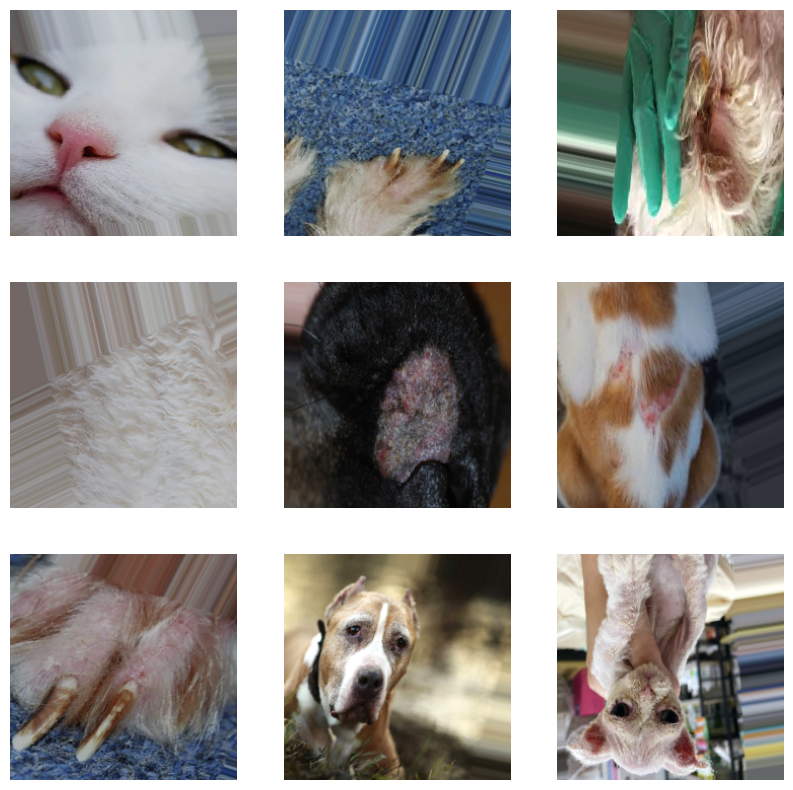

In [ ]:
# Get a batch of images
sample_images, sample_labels = next(train_generator)

# Plot 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    plt.axis('off')
plt.show()

# Weights


In [ ]:
from sklearn.utils import class_weight
import numpy as np

# Class weights
train_classes = train_generator.classes
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_classes), y=train_classes)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weights_dict)  # This prints the computed class weights for each class

Class Weights: {0: 1.212962962962963, 1: 1.0679347826086956, 2: 0.8256302521008403, 3: 0.9727722772277227}


# Model

In [ ]:
from tf_keras.models import Model
from tf_keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, SpatialDropout2D
from tf_keras.applications import MobileNetV3Small
from tf_keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tf_keras.optimizers import Adam
from tf_keras.regularizers import l2
from tf_keras.callbacks import Callbacks

base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))

# Custom top layers with Batch Normalization, L2 Regularization, and SpatialDropout2D
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)  # Use Dropout instead of SpatialDropout2D
x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)  # Assuming 4 classes

model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze last layers for fine-tuning
for layer in base_model.layers[-30:]:  # Fine-tune more layers
    layer.trainable = True

# Compile with a slightly higher initial learning rate for faster convergence
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
checkpoint = ModelCheckpoint("best_model_mobilenetv3.h5", monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                                    

# Train The Model

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=70,  # Extended epochs for more thorough training
    class_weight=class_weights_dict,
    callbacks=[reduce_lr, checkpoint, early_stopping]
)

Epoch 1/70
7/7 [==============================] - ETA: 0s - loss: 2.6022 - accuracy: 0.2875

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


7/7 [==============================] - 60s 6s/step - loss: 2.6022 - accuracy: 0.2875 - val_loss: 1.9588 - val_accuracy: 0.2990 - lr: 0.0010
Epoch 2/70
7/7 [==============================] - 35s 5s/step - loss: 2.3019 - accuracy: 0.3868 - val_loss: 2.0039 - val_accuracy: 0.3093 - lr: 0.0010
Epoch 3/70
7/7 [==============================] - 35s 5s/step - loss: 2.1327 - accuracy: 0.3969 - val_loss: 2.1055 - val_accuracy: 0.2990 - lr: 0.0010
Epoch 4/70
7/7 [==============================] - 30s 4s/step - loss: 1.9254 - accuracy: 0.4936 - val_loss: 2.1664 - val_accuracy: 0.3093 - lr: 0.0010
Epoch 5/70
7/7 [==============================] - 31s 4s/step - loss: 1.9935 - accuracy: 0.4682 - val_loss: 2.2395 - val_accuracy: 0.2990 - lr: 5.0000e-04
Epoch 6/70
7/7 [==============================] - 30s 4s/step - loss: 1.9040 - accuracy: 0.5089 - val_loss: 2.2536 - val_accuracy: 0.3196 - lr: 5.0000e-04
Epoch 7/70
7/7 [==============================] - 31s 5s/step - loss: 1.9043 - accuracy: 0.5191 -

# Fine Tuning The Model

In [ ]:
# Fine-Tuning Stage with Lower Learning Rate
for layer in base_model.layers[-30:]:
    layer.trainable = True


In [ ]:
# Further training with additional epochs
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[reduce_lr, checkpoint, early_stopping]
)

Epoch 1/30
7/7 [==============================] - 33s 5s/step - loss: 2.1704 - accuracy: 0.3969 - val_loss: 1.9824 - val_accuracy: 0.2990 - lr: 1.9531e-06
Epoch 2/30
7/7 [==============================] - 30s 5s/step - loss: 2.1992 - accuracy: 0.4300 - val_loss: 1.9295 - val_accuracy: 0.3402 - lr: 1.9531e-06
Epoch 3/30
7/7 [==============================] - 31s 5s/step - loss: 2.2495 - accuracy: 0.4046 - val_loss: 1.9874 - val_accuracy: 0.2990 - lr: 1.9531e-06
Epoch 4/30
7/7 [==============================] - 31s 5s/step - loss: 2.0715 - accuracy: 0.4148 - val_loss: 1.9938 - val_accuracy: 0.2784 - lr: 1.9531e-06
Epoch 5/30
7/7 [==============================] - 30s 5s/step - loss: 2.1648 - accuracy: 0.4097 - val_loss: 1.9947 - val_accuracy: 0.2990 - lr: 1.9531e-06
Epoch 6/30
7/7 [==============================] - 30s 5s/step - loss: 2.0534 - accuracy: 0.4402 - val_loss: 1.9893 - val_accuracy: 0.2887 - lr: 1.0000e-06
Epoch 7/30
7/7 [==============================] - 32s 5s/step - loss: 

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model saved as model.tflite")

Model saved as model.tflite


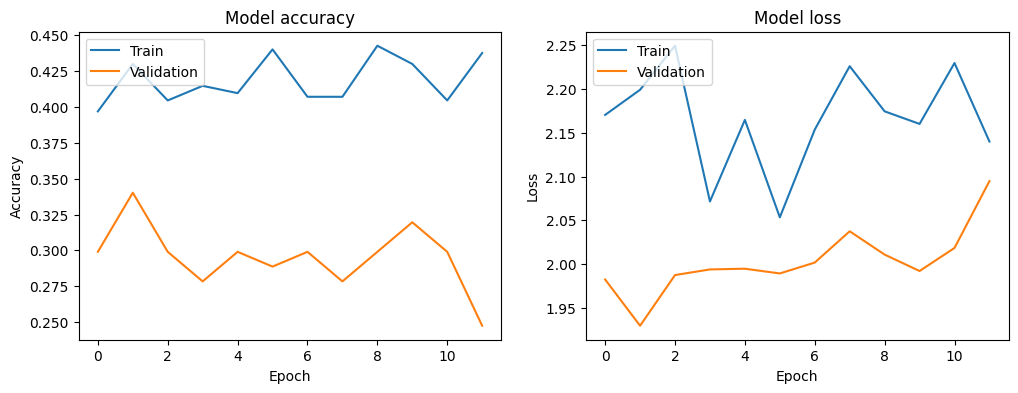

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()